# scholar_data_strategy

### 1. Load Data

In [488]:
import warnings
warnings.filterwarnings("ignore")

import pyfolio as pf
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from pandas_datareader import data as pdr
import yfinance as yf

path = '/Users/ChrisQAQ/Downloads/ICAF_2020/data/'

from ml_models import _run_model
from ml_models import _long_only_strategy_daily
from ml_models import _long_only_strategy_monthly
from  matplotlib import pyplot as plt
%matplotlib inline
import scipy.optimize as sco

import tensorflow
print (tensorflow.__version__)

2.1.0


In [68]:
feature_df = pd.read_csv(path+'result/fin+paper_feature_table.csv')
feature_df.shape

(15253, 67)

In [70]:
feature_df.columns

Index(['month', 'ticker', 'gsector', 'epspiq', 'prccq', 'pe_inc', 'ptb', 'ps',
       'roa', 'roe', 'quick_ratio', 'curr_ratio', 'npm', 'de_ratio', 'date',
       'adj_closed_price', 'monthly_return', 'forward_monthly_return',
       'paper_month', 'total_count', 'total_citation', 'journal_count',
       'journal_citation', 'patent_count', 'patent_citation', 'article_count',
       'article_citation', 'conference_count', 'conference_citation',
       'book_count', 'book_citation', 'total_count_cumsum',
       'total_citation_cumsum', 'journal_count_cumsum',
       'journal_citation_cumsum', 'patent_count_cumsum',
       'patent_citation_cumsum', 'article_count_cumsum',
       'article_citation_cumsum', 'conference_count_cumsum',
       'conference_citation_cumsum', 'book_count_cumsum',
       'book_citation_cumsum', 'total_max_citation', 'total_average_citation',
       'patent_max_citation', 'patent_average_citation',
       'journal_max_citation', 'journal_average_citation',
       '

In [71]:
features_column_alternative = ['total_count', 'total_citation', 'journal_count',
       'journal_citation', 'patent_count', 'patent_citation', 'article_count',
       'article_citation', 'conference_count', 'conference_citation',
       'book_count', 'book_citation', 'total_count_cumsum',
       'total_citation_cumsum', 'journal_count_cumsum',
       'journal_citation_cumsum', 'patent_count_cumsum',
       'patent_citation_cumsum', 'article_count_cumsum',
       'article_citation_cumsum', 'conference_count_cumsum',
       'conference_citation_cumsum', 'book_count_cumsum',
       'book_citation_cumsum', 'total_max_citation', 'total_average_citation',
       'patent_max_citation', 'patent_average_citation',
       'journal_max_citation', 'journal_average_citation',
       'article_max_citation', 'article_average_citation',
       'conference_max_citation', 'conference_average_citation',
       'book_max_citation', 'book_average_citation', 'total_count_relative',
       'total_count_relative_cumsum', 'journal_count_relative',
       'journal_count_relative_cumsum', 'patent_count_relative',
       'patent_count_relative_cumsum', 'article_count_relative',
       'article_count_relative_cumsum', 'conference_count_relative',
       'conference_count_relative_cumsum', 'book_count_relative',
       'book_count_relative_cumsum']

print(f'# of scholar features: {len(features_column_alternative)}')

features_column_financial = ['epspiq', 'pe_inc', 'ptb', 'ps',
       'roa', 'roe', 'quick_ratio', 'curr_ratio', 'npm', 'de_ratio']

print(f'# of financial features: {len(features_column_financial)}')

features_column_all = features_column_alternative + features_column_financial
print(f'# of all features: {len(features_column_all)}')

# of scholar features: 48
# of financial features: 10
# of all features: 58


### 2. Data Prep

In [170]:
# get a subset of period, given 2008-01 to 2018-12
feature_df = feature_df[(feature_df.month>='2004-01') & (feature_df.month<='2019-01')]

In [171]:
# unique_ticker
unique_ticker = sorted(feature_df.ticker.unique())
print(f'# of tickers: {len(unique_ticker)}')

# unique_datetime
unique_datetime = sorted(feature_df.date.unique())
print(f'# of months: {len(unique_datetime)}')

print(f'start date: {min(unique_datetime)}')
print(f'end date: {max(unique_datetime)}')

# trade_month
trade_month = unique_datetime[60:]
print(f'trade start month: {unique_datetime[60]}')
print(f'# of trade months: {len(trade_month)}')

# of tickers: 88
# of months: 181
start date: 2004-01-01
end date: 2019-01-01
trade start month: 2009-01-01
# of trade months: 121


In [172]:
tic_monthly_return = feature_df.pivot('date','ticker','monthly_return')
tic_monthly_return = tic_monthly_return.reset_index()
tic_monthly_return.index = tic_monthly_return.date
del tic_monthly_return['date']
tic_monthly_return = tic_monthly_return[tic_monthly_return.index >= unique_datetime[60]]
print(tic_monthly_return.shape)

(121, 88)


In [174]:
# get daily return 
startdate='2004-01-01'
enddate='2019-01-31'

# download price data
stockdata = pdr.get_data_yahoo(feature_df.ticker.unique(), start=startdate, end=enddate)
closeadj = stockdata['Adj Close'].fillna(method='ffill').fillna(method='bfill')
daily_return = (closeadj-closeadj.shift(1))/closeadj.shift(1)*100
daily_return = daily_return.drop(daily_return.index[0]).fillna(0)

daily_return.head()

Symbols         AAPL      ACLS      ADBE       ADI      ADSK      AKAM  \
Date                                                                     
2004-01-05  4.182336  5.200005  1.790270  3.079342  0.897963  2.133585   
2004-01-06 -0.360856  2.661594  0.100514  2.245687 -0.566333  8.810166   
2004-01-07  2.263476  2.129625 -0.971714  0.994622  0.854342  5.926545   
2004-01-08  3.408598  2.901185 -3.651114  1.785004  0.645440  2.442872   
2004-01-09 -1.541120  0.792944 -2.315789 -1.592421 -1.202421  1.769227   

Symbols         AMAT       AMD      AMKR  ANET  ...       TER       TXN  \
Date                                            ...                       
2004-01-05  6.425347  2.288023  6.325630   0.0  ...  4.333988  2.115308   
2004-01-06  1.700656  2.697367  0.258661   0.0  ...  0.724046  0.200455   
2004-01-07 -0.334418  0.320309  1.805988   0.0  ...  0.454043 -0.133346   
2004-01-08  1.845646  1.724141  3.041056   0.0  ...  4.670448  6.343922   
2004-01-09 -0.082393 -2.448213 -1.032952   0.0  ... -0.827637 -0.219815   

Symbols          UIS    V      VECO  VMW      VSAT   WU      XLNX       XRX  
Date                                                                         
2004-01-05  2.633352  0.0  8.571430  0.0  4.937634  0.0  3.219940  1.692444  
2004-01-06 -1.842107  0.0  1.364523  0.0  1.832585  0.0 -0.628962  1.808953  
2004-01-07 -0.402139  0.0 -0.897438  0.0  6.322963  0.0 -0.987290  0.355417  
2004-01-08  3.499325  0.0  1.067270  0.0  4.071360  0.0  4.270041  0.283267  
2004-01-09 -3.055915  0.0 -1.567999  0.0  0.439562  0.0 -0.809279 -1.412465  

[5 rows x 88 columns]

In [175]:
print(daily_return.shape)

(3795, 88)


In [176]:
# df_equally_portfolio_return

equally_portfolio_return=[]
for i in range(len(trade_month)):
    return_remove_nan = tic_monthly_return.iloc[i][~np.isnan(tic_monthly_return.iloc[i])]
    equally_portfolio_return.append(sum(return_remove_nan)/len(return_remove_nan))
    
df_equally_portfolio_return=pd.DataFrame(equally_portfolio_return,trade_month)
df_equally_portfolio_return=df_equally_portfolio_return.reset_index()
df_equally_portfolio_return.columns= ['trade_month','monthly_return']
df_equally_portfolio_return.index=df_equally_portfolio_return.trade_month
df_equally_portfolio_return=df_equally_portfolio_return['monthly_return']

print(df_equally_portfolio_return.shape)

(121,)


In [177]:
trade_month_plus1=trade_month.copy()
trade_month_plus1.append('2019-02-01')
print(len(trade_month))
print(len(trade_month_plus1))

121
122


In [178]:
# calculate actual monthly return
log_daily_return = np.log(daily_return/100+1)
log_monthly_return = log_daily_return.groupby(pd.Grouper(freq='M')).apply(sum)

# calculate rolling return variance
monthly_return_val = pd.DataFrame(columns=log_monthly_return.columns)
for i in range(len(trade_month)):
    trade_mon = pd.to_datetime(trade_month[i])
    start_mon = trade_mon + pd.DateOffset(months=-42)
    end_mon   = trade_mon + pd.DateOffset(months=-6)
    return_mat = log_monthly_return[(log_monthly_return.index > start_mon)&(log_monthly_return.index < end_mon)]
    val_vec = return_mat.apply(np.std)
    monthly_return_val.loc[trade_mon,] = val_vec

monthly_return_val = monthly_return_val.replace(0, np.nan)
monthly_return_val = monthly_return_val.bfill()
print(monthly_return_val.shape)
print(monthly_return_val.isnull().sum().sum())
print((monthly_return_val==0).sum().sum())

(121, 88)
0
0


### 3. Run Models

Implement ML models on different feature spaces.

* financial feature space 
* ESG sholar feature space + financial feature space


### 3.1 Financial Data Only

In [179]:
#%%time
start = time.time()
model_results2 = _run_model(feature_df, unique_ticker, unique_datetime, trade_month,
                            features_column_financial, first_trade_date_index=60, testing_windows=12)
end = time.time()

Epoch 1/2
3231/3231 [==============================] - 2s 487us/step - loss: 0.0908
Epoch 2/2
3231/3231 [==============================] - 1s 194us/step - loss: 0.0849
Trade Month:  2009-02-01
Epoch 1/2
3240/3240 [==============================] - 1s 461us/step - loss: 0.0932
Epoch 2/2
3240/3240 [==============================] - 1s 175us/step - loss: 0.0851
Trade Month:  2009-03-01
Epoch 1/2
3249/3249 [==============================] - 1s 459us/step - loss: 0.0904
Epoch 2/2
3249/3249 [==============================] - 1s 176us/step - loss: 0.0851
Trade Month:  2009-04-01
Epoch 1/2
3257/3257 [==============================] - 1s 446us/step - loss: 0.0950
Epoch 2/2
3257/3257 [==============================] - 1s 175us/step - loss: 0.0846
Trade Month:  2009-05-01
Epoch 1/2
3266/3266 [==============================] - 1s 454us/step - loss: 0.0923
Epoch 2/2
3266/3266 [==============================] - 1s 177us/step - loss: 0.0839
Trade Month:  2009-06-01
Epoch 1/2
3275/3275 [==============

3588/3588 [==============================] - 1s 184us/step - loss: 0.1056
Trade Month:  2012-08-01
Epoch 1/2
3594/3594 [==============================] - 2s 423us/step - loss: 0.1176
Epoch 2/2
3594/3594 [==============================] - 1s 181us/step - loss: 0.1047
Trade Month:  2012-09-01
Epoch 1/2
3600/3600 [==============================] - 2s 424us/step - loss: 0.1128
Epoch 2/2
3600/3600 [==============================] - 1s 182us/step - loss: 0.1071
Trade Month:  2012-10-01
Epoch 1/2
3606/3606 [==============================] - 2s 442us/step - loss: 0.1230
Epoch 2/2
3606/3606 [==============================] - 1s 178us/step - loss: 0.1073
Trade Month:  2012-11-01
Epoch 1/2
3612/3612 [==============================] - 2s 478us/step - loss: 0.1128
Epoch 2/2
3612/3612 [==============================] - 1s 193us/step - loss: 0.1063
Trade Month:  2012-12-01
Epoch 1/2
3617/3617 [==============================] - 2s 426us/step - loss: 0.1127
Epoch 2/2
3617/3617 [========================

Epoch 1/2
3833/3833 [==============================] - 2s 425us/step - loss: 0.0802
Epoch 2/2
3833/3833 [==============================] - 1s 181us/step - loss: 0.0735
Trade Month:  2016-03-01
Epoch 1/2
3837/3837 [==============================] - 2s 407us/step - loss: 0.0796
Epoch 2/2
3837/3837 [==============================] - 1s 180us/step - loss: 0.0730
Trade Month:  2016-04-01
Epoch 1/2
3841/3841 [==============================] - 2s 419us/step - loss: 0.0864
Epoch 2/2
3841/3841 [==============================] - 1s 184us/step - loss: 0.0740
Trade Month:  2016-05-01
Epoch 1/2
3845/3845 [==============================] - 2s 427us/step - loss: 0.0762
Epoch 2/2
3845/3845 [==============================] - 1s 180us/step - loss: 0.0727
Trade Month:  2016-06-01
Epoch 1/2
3849/3849 [==============================] - 2s 437us/step - loss: 0.0768
Epoch 2/2
3849/3849 [==============================] - 1s 185us/step - loss: 0.0719
Trade Month:  2016-07-01
Epoch 1/2
3853/3853 [==============

In [180]:
# get return
df_predict_lr2       = model_results2[0].astype(np.float64)
df_predict_lasso2    = model_results2[1].astype(np.float64)
df_predict_ridge2    = model_results2[2].astype(np.float64)
df_predict_rf2       = model_results2[3].astype(np.float64)
df_predict_svm2      = model_results2[4].astype(np.float64)
df_predict_lstm2     = model_results2[5].astype(np.float64)
df_predict_best2     = model_results2[6].astype(np.float64)
df_best_model_name2  = model_results2[7]
df_evaluation_score2 = model_results2[8]

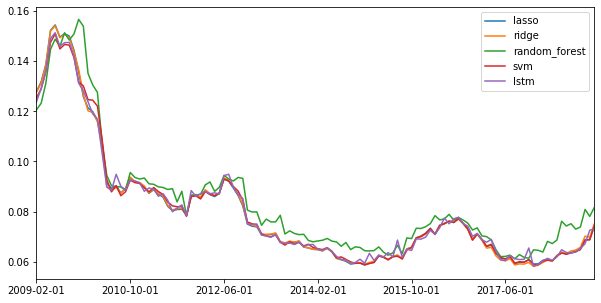

In [181]:
evaluation_list = []
for i in range(df_predict_best2.shape[0]-1):
    evaluation_list.append(df_evaluation_score2[i]['model_eval'].values)
df_evaluation2 = pd.DataFrame(evaluation_list,columns = ['linear_regression', 'lasso','ridge','random_forest','svm','lstm'])
df_evaluation2.index = df_predict_best2.index.values[1:]

df_evaluation2[['lasso','ridge','random_forest','svm','lstm']].plot(figsize=(10,5))
#plt.plot(df_evaluation)

In [182]:
df_best_model_name2.head()

model_name
2009-01-01        NaN
2009-02-01         rf
2009-03-01         rf
2009-04-01         rf
2009-05-01         rf

In [183]:
df_best_model_name2[(df_best_model_name2.index>='2009-01-01')& (df_best_model_name2.index<'2019-02-01')].model_name.value_counts()


svm      33
lasso    28
lstm     25
ridge    16
lr       13
rf        5
Name: model_name, dtype: int64

In [184]:
# get daily return
df_portfolio_best_daily2  = _long_only_strategy_daily(df_predict_best2,  daily_return,trade_month_plus1,top_quantile_threshold = 0.75)

df_portfolio_lasso_daily2 = _long_only_strategy_daily(df_predict_lasso2, daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_ridge_daily2 = _long_only_strategy_daily(df_predict_ridge2, daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_rf_daily2    = _long_only_strategy_daily(df_predict_rf2,    daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_svm_daily2   = _long_only_strategy_daily(df_predict_svm2,   daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_lstm_daily2  = _long_only_strategy_daily(df_predict_lstm2,  daily_return,trade_month_plus1,top_quantile_threshold = 0.75)


In [185]:
# get monthly return
df_portfolio_return_lasso2 = _long_only_strategy_monthly(df_predict_lasso2,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_ridge2 = _long_only_strategy_monthly(df_predict_ridge2,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_rf2    = _long_only_strategy_monthly(df_predict_rf2,   tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_svm2   = _long_only_strategy_monthly(df_predict_svm2,  tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_lstm2  = _long_only_strategy_monthly(df_predict_lstm2, tic_monthly_return,trade_month,top_quantile_threshold = 0.75)

df_portfolio_return_best2  = _long_only_strategy_monthly(df_predict_best2, tic_monthly_return,trade_month,top_quantile_threshold = 0.75)


Text(0.5, 1.0, 'Cumulative Return')

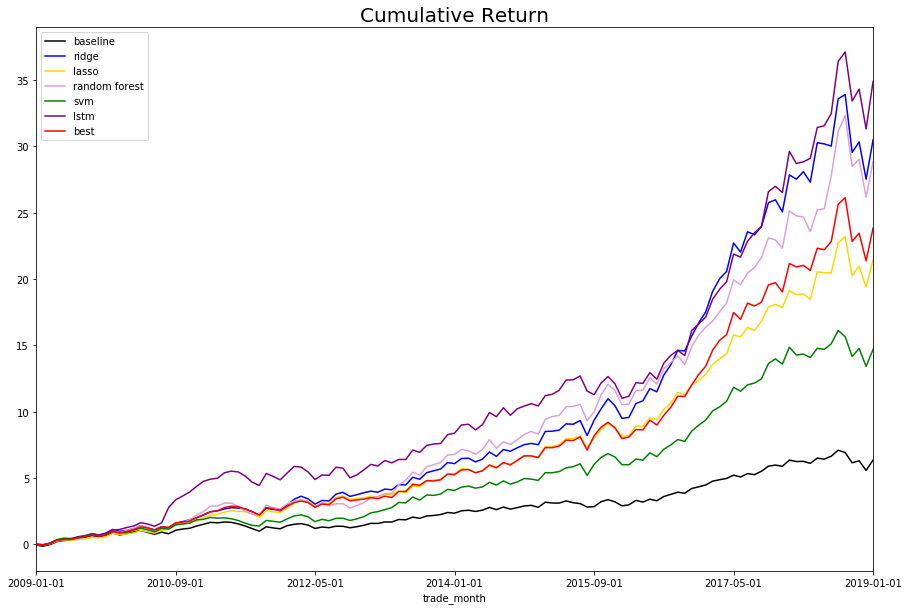

In [186]:
plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

ridge = ((df_portfolio_return_ridge2+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso2+1).cumprod()-1).plot(c='gold',label='lasso')
rf = ((df_portfolio_return_rf2+1).cumprod()-1).plot(c='plum',label='random forest')
svm = ((df_portfolio_return_svm2+1).cumprod()-1).plot(c='green',label='svm')
lstm = ((df_portfolio_return_lstm2+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best2+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)

### 3.2 Scholar + Financial Data 

In [187]:
import warnings
warnings.filterwarnings('ignore')

In [188]:
#%%time
start = time.time()
model_results3 = _run_model(feature_df, unique_ticker, unique_datetime, trade_month,
                            features_column_all, first_trade_date_index=60, testing_windows=12)
end = time.time()

Epoch 1/2
3231/3231 [==============================] - 5s 1ms/step - loss: 0.0906
Epoch 2/2
3231/3231 [==============================] - 4s 1ms/step - loss: 0.0861
Trade Month:  2009-02-01
Epoch 1/2
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0924
Epoch 2/2
3240/3240 [==============================] - 4s 1ms/step - loss: 0.0862
Trade Month:  2009-03-01
Epoch 1/2
3249/3249 [==============================] - 5s 1ms/step - loss: 0.0905
Epoch 2/2
3249/3249 [==============================] - 4s 1ms/step - loss: 0.0855
Trade Month:  2009-04-01
Epoch 1/2
3257/3257 [==============================] - 4s 1ms/step - loss: 0.0887
Epoch 2/2
3257/3257 [==============================] - 4s 1ms/step - loss: 0.0839
Trade Month:  2009-05-01
Epoch 1/2
3266/3266 [==============================] - 5s 1ms/step - loss: 0.0911
Epoch 2/2
3266/3266 [==============================] - 4s 1ms/step - loss: 0.0857
Trade Month:  2009-06-01
Epoch 1/2
3275/3275 [==============================] - 

3837/3837 [==============================] - 5s 1ms/step - loss: 0.0791
Epoch 2/2
3837/3837 [==============================] - 4s 1ms/step - loss: 0.0731
Trade Month:  2016-04-01
Epoch 1/2
3841/3841 [==============================] - 5s 1ms/step - loss: 0.0846
Epoch 2/2
3841/3841 [==============================] - 5s 1ms/step - loss: 0.0729
Trade Month:  2016-05-01
Epoch 1/2
3845/3845 [==============================] - 6s 1ms/step - loss: 0.0787
Epoch 2/2
3845/3845 [==============================] - 4s 1ms/step - loss: 0.0722
Trade Month:  2016-06-01
Epoch 1/2
3849/3849 [==============================] - 5s 1ms/step - loss: 0.0791
Epoch 2/2
3849/3849 [==============================] - 4s 1ms/step - loss: 0.0718
Trade Month:  2016-07-01
Epoch 1/2
3853/3853 [==============================] - 6s 1ms/step - loss: 0.0769
Epoch 2/2
3853/3853 [==============================] - 5s 1ms/step - loss: 0.0718
Trade Month:  2016-08-01
Epoch 1/2
3857/3857 [==============================] - 5s 1ms/ste

In [189]:
# get return
df_predict_lr3       = model_results3[0].astype(np.float64)
df_predict_lasso3    = model_results3[1].astype(np.float64)
df_predict_ridge3    = model_results3[2].astype(np.float64)
df_predict_rf3       = model_results3[3].astype(np.float64)
df_predict_svm3      = model_results3[4].astype(np.float64)
df_predict_lstm3     = model_results3[5].astype(np.float64)
df_predict_best3     = model_results3[6].astype(np.float64)
df_best_model_name3  = model_results3[7]
df_evaluation_score3 = model_results3[8]

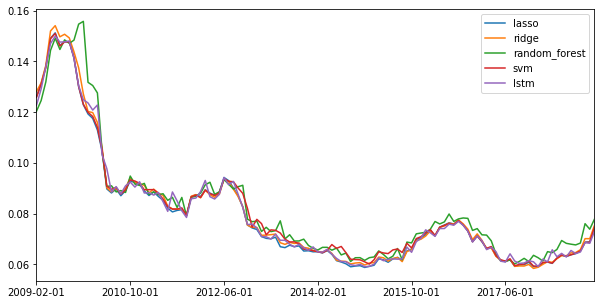

In [190]:
evaluation_list = []
for i in range(df_predict_best3.shape[0]-1):
    evaluation_list.append(df_evaluation_score3[i]['model_eval'].values)
df_evaluation3 = pd.DataFrame(evaluation_list,columns = ['linear_regression', 'lasso','ridge','random_forest','svm','lstm'])
df_evaluation3.index = df_predict_best3.index.values[1:]

df_evaluation3[['lasso','ridge','random_forest','svm','lstm']].plot(figsize=(10,5))
#plt.plot(df_evaluation)

In [191]:
df_best_model_name3.head()

model_name
2009-01-01        NaN
2009-02-01         rf
2009-03-01         rf
2009-04-01         rf
2009-05-01         rf

In [192]:
df_best_model_name3[(df_best_model_name3.index>='2009-01-01')& (df_best_model_name3.index<'2019-02-01')].model_name.value_counts()


lstm     44
lasso    42
ridge    17
rf       12
svm       3
lr        2
Name: model_name, dtype: int64

In [318]:
df_best_model_name3[(df_best_model_name3.index>='2009-01-01')& (df_best_model_name3.index<'2019-02-01')].model_name.value_counts()/sum(df_best_model_name3[(df_best_model_name3.index>='2009-01-01')& (df_best_model_name3.index<'2019-02-01')].model_name.value_counts()
)


lstm     0.366667
lasso    0.350000
ridge    0.141667
rf       0.100000
svm      0.025000
lr       0.016667
Name: model_name, dtype: float64

In [193]:
# get daily return
df_portfolio_best_daily3  = _long_only_strategy_daily(df_predict_best3,  daily_return,trade_month_plus1,top_quantile_threshold = 0.75)

df_portfolio_lasso_daily3 = _long_only_strategy_daily(df_predict_lasso3, daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_ridge_daily3 = _long_only_strategy_daily(df_predict_ridge3, daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_rf_daily3    = _long_only_strategy_daily(df_predict_rf3,    daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_svm_daily3   = _long_only_strategy_daily(df_predict_svm3,   daily_return,trade_month_plus1,top_quantile_threshold = 0.75)
df_portfolio_lstm_daily3  = _long_only_strategy_daily(df_predict_lstm3,  daily_return,trade_month_plus1,top_quantile_threshold = 0.75)


In [194]:
# get monthly return
df_portfolio_return_lasso3 = _long_only_strategy_monthly(df_predict_lasso3,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_ridge3 = _long_only_strategy_monthly(df_predict_ridge3,tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_rf3    = _long_only_strategy_monthly(df_predict_rf3,   tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_svm3   = _long_only_strategy_monthly(df_predict_svm3,  tic_monthly_return,trade_month,top_quantile_threshold = 0.75)
df_portfolio_return_lstm3  = _long_only_strategy_monthly(df_predict_lstm3, tic_monthly_return,trade_month,top_quantile_threshold = 0.75)

df_portfolio_return_best3  = _long_only_strategy_monthly(df_predict_best3, tic_monthly_return,trade_month,top_quantile_threshold = 0.75)


Text(0.5, 1.0, 'Cumulative Return')

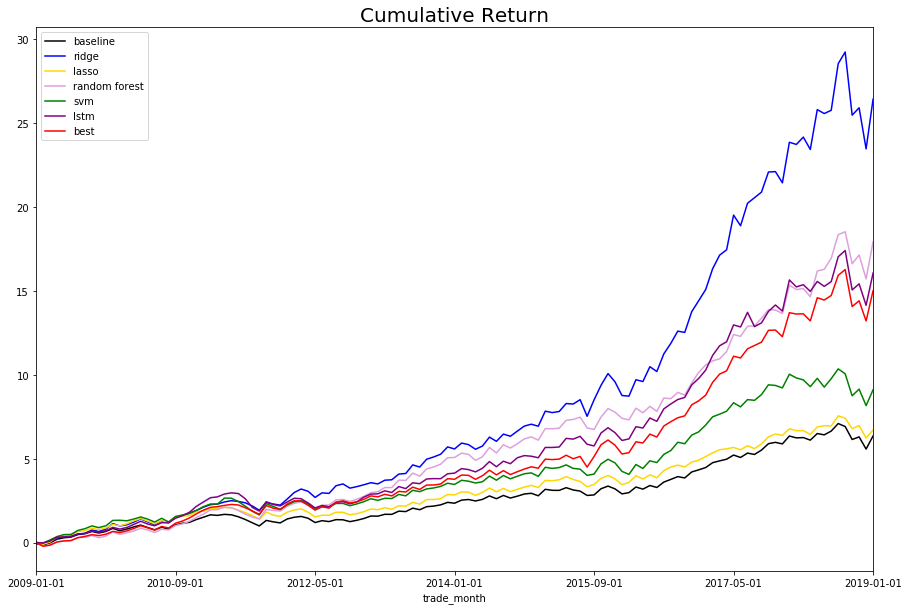

In [195]:
plt.figure(figsize=(15,10))

baseline = ((df_equally_portfolio_return+1).cumprod()-1).plot(c='black',label='baseline')

ridge = ((df_portfolio_return_ridge3+1).cumprod()-1).plot(c='b',label='ridge')
lasso = ((df_portfolio_return_lasso3+1).cumprod()-1).plot(c='gold',label='lasso')
rf = ((df_portfolio_return_rf3+1).cumprod()-1).plot(c='plum',label='random forest')
svm = ((df_portfolio_return_svm3+1).cumprod()-1).plot(c='green',label='svm')
lstm = ((df_portfolio_return_lstm3+1).cumprod()-1).plot(c='purple',label='lstm')

best = ((df_portfolio_return_best3+1).cumprod()-1).plot(c='r',label='best')
plt.legend()


plt.title('Cumulative Return',size=20)

### 4. Output Results Files

### 4.1 Financial Only

In [111]:
path2 = path+'result/financial/'

# get return
df_predict_lr2.to_csv(path2+'df_predict_lr2.csv')      
df_predict_lasso2.to_csv(path2+'df_predict_lasso2.csv')
df_predict_ridge2.to_csv(path2+'df_predict_ridge2.csv')   
df_predict_rf2.to_csv(path2+'df_predict_rf2.csv')      
df_predict_svm2.to_csv(path2+'df_predict_svm2.csv')     
df_predict_lstm2.to_csv(path2+'df_predict_lstm2.csv')    
df_predict_best2.to_csv(path2+'df_predict_best2.csv')    
df_best_model_name2.to_csv(path2+'df_best_model_name2.csv') 

# get daily return
df_portfolio_best_daily2[1].to_csv(path2+'df_portfolio_best_daily2.csv') 
df_portfolio_lasso_daily2[1].to_csv(path2+'df_portfolio_lasso_daily2.csv')
df_portfolio_ridge_daily2[1].to_csv(path2+'df_portfolio_ridge_daily2.csv')
df_portfolio_rf_daily2[1].to_csv(path2+'df_portfolio_rf_daily2.csv')   
df_portfolio_svm_daily2[1].to_csv(path2+'df_portfolio_svm_daily2.csv')  
df_portfolio_lstm_daily2[1].to_csv(path2+'df_portfolio_lstm_daily2.csv') 

# get monthly return
df_portfolio_return_lasso2.to_csv(path2+'df_portfolio_return_lasso2.csv')
df_portfolio_return_ridge2.to_csv(path2+'df_portfolio_return_ridge2.csv')
df_portfolio_return_rf2.to_csv(path2+'df_portfolio_return_rf2.csv')   
df_portfolio_return_svm2.to_csv(path2+'df_portfolio_return_svm2.csv')  
df_portfolio_return_lstm2.to_csv(path2+'df_portfolio_return_lstm2.csv') 
df_portfolio_return_best2.to_csv(path2+'df_portfolio_return_best2.csv') 


### 4.2 Scholar + Financial

In [112]:
path3 = path+'result/scholar+financial/'

# get return
df_predict_lr3.to_csv(path3+'df_predict_lr3.csv')      
df_predict_lasso3.to_csv(path3+'df_predict_lasso3.csv')
df_predict_ridge3.to_csv(path3+'df_predict_ridge3.csv')   
df_predict_rf3.to_csv(path3+'df_predict_rf3.csv')      
df_predict_svm3.to_csv(path3+'df_predict_svm3.csv')     
df_predict_lstm3.to_csv(path3+'df_predict_lstm3.csv')    
df_predict_best3.to_csv(path3+'df_predict_best3.csv')    
df_best_model_name3.to_csv(path3+'df_best_model_name3.csv') 

# get daily return
df_portfolio_best_daily3[1].to_csv(path3+'df_portfolio_best_daily3.csv') 
df_portfolio_lasso_daily3[1].to_csv(path3+'df_portfolio_lasso_daily3.csv')
df_portfolio_ridge_daily3[1].to_csv(path3+'df_portfolio_ridge_daily3.csv')
df_portfolio_rf_daily3[1].to_csv(path3+'df_portfolio_rf_daily3.csv')   
df_portfolio_svm_daily3[1].to_csv(path3+'df_portfolio_svm_daily3.csv')  
df_portfolio_lstm_daily3[1].to_csv(path3+'df_portfolio_lstm_daily3.csv') 

# get monthly return
df_portfolio_return_lasso3.to_csv(path3+'df_portfolio_return_lasso3.csv')
df_portfolio_return_ridge3.to_csv(path3+'df_portfolio_return_ridge3.csv')
df_portfolio_return_rf3.to_csv(path3+'df_portfolio_return_rf3.csv')   
df_portfolio_return_svm3.to_csv(path3+'df_portfolio_return_svm3.csv')  
df_portfolio_return_lstm3.to_csv(path3+'df_portfolio_return_lstm3.csv') 
df_portfolio_return_best3.to_csv(path3+'df_portfolio_return_best3.csv')


### 5. Evaluation

In [201]:
# df_portfolio_best_daily3 -- scholar and finicial / equal weights

# df_portfolio_best_daily2 -- financial / equal weights

startdate = '2009-01-01'
enddate = '2018-12-31'

# download the NDX data
NDX = yf.download("^NDX",start=startdate,end=enddate)
# NDX return
NDXreturn=(NDX['Adj Close']-NDX['Adj Close'].shift(1))/NDX['Adj Close'].shift(1)  * 100
NDXreturn= NDXreturn.drop(NDXreturn.index[0])

# download the SP500 data
SPY = yf.download("SPY",start=startdate,end=enddate)
# SPY return
SPYreturn=(SPY['Adj Close']-SPY['Adj Close'].shift(1))/SPY['Adj Close'].shift(1)  * 100
SPYreturn= SPYreturn.drop(SPYreturn.index[0])

allreturns = pd.DataFrame(pf.ep.cum_returns(returns=NDXreturn/100),columns=['Nasdaq100'])
allreturns['S&P 500'] = pf.ep.cum_returns(returns=SPYreturn/100)

# financial / equal weights
returns1 = df_portfolio_best_daily2[1]
returns1 = returns1[returns1.index.isin(SPYreturn.index)]
allreturns['Financial Equal Weights'] = pf.ep.cum_returns(returns=returns1/100)

# financial + scholar / equal weights
returns2 = df_portfolio_best_daily3[1]
returns2 = returns2[returns2.index.isin(SPYreturn.index)]
allreturns['Scholar Equal Weights'] = pf.ep.cum_returns(returns=returns2/100)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 5.1 Test: 25% Quantile Risk Adjusted Return + Equally weighted

In [202]:
def _max_risk_adjusted_strategy_daily(df_predict_return, daily_return, monthly_return_val,
                                      trade_month_plus1, top_quantile_threshold=0.7):
    long_dict = {}
    top_stocks=pd.DataFrame()
    risk_adjusted_return = pd.DataFrame()
    for tic in df_predict_return.columns:
        risk_adjusted_return[tic] = df_predict_return[tic]/monthly_return_val[tic]
    
    for i in range(df_predict_return.shape[0]):
        top_q = risk_adjusted_return.iloc[i].quantile(top_quantile_threshold)
        # Select Top 30% Stocks
        long_dict[risk_adjusted_return.index[i]] = df_predict_return.iloc[i][risk_adjusted_return.iloc[i] >= top_q]
        temp_stocks = df_predict_return.iloc[i][risk_adjusted_return.iloc[i] >= top_q].reset_index()
        temp_stocks.columns = ['tic','predicted_return']
        temp_stocks['trade_date'] = df_predict_return.index[i]

        top_stocks=top_stocks.append(temp_stocks,ignore_index=True)        

    df_portfolio_return_daily = pd.DataFrame(columns=['daily_return'])
    for i in range(len(trade_month_plus1) - 2):
        # for long only
        #equally weight
        long_normalize_weight = 1/long_dict[trade_month_plus1[i+1]].shape[0]
        
        # calculate weight based on predicted return
        #long_normalize_weight = \
        #long_dict[trade_month_plus1[i]] / sum(long_dict[trade_month_plus1[i]].values)
        # map date and tic
        long_tic_return_daily = \
        daily_return[(daily_return.index >= trade_month_plus1[i]) & (daily_return.index < trade_month_plus1[i + 1])][
            long_dict[trade_month_plus1[i]].index]
        # return * weight
        long_daily_return = long_tic_return_daily * long_normalize_weight
        df_temp = long_daily_return.sum(axis=1)
        df_temp = pd.DataFrame(df_temp, columns=['daily_return'])
        df_portfolio_return_daily = df_portfolio_return_daily.append(df_temp)

    return top_stocks,df_portfolio_return_daily


In [203]:
# financial + scholar / top + equal weights
scholar_top_equal_daily   = _max_risk_adjusted_strategy_daily(df_predict_best3,  daily_return, monthly_return_val+0.001, trade_month_plus1, top_quantile_threshold=0.75)
returns3 = scholar_top_equal_daily[1]
returns3 = returns3[returns3.index.isin(SPYreturn.index)]
allreturns['Scholar Top Equal Weights'] = pf.ep.cum_returns(returns=returns3/100)

# financial / top + equal weights
financial_top_equal_daily = _max_risk_adjusted_strategy_daily(df_predict_best2,  daily_return, monthly_return_val+0.001, trade_month_plus1, top_quantile_threshold=0.75)
returns4 = financial_top_equal_daily[1]
returns4 = returns4[returns4.index.isin(SPYreturn.index)]
allreturns['Financial Top Equal Weights'] = pf.ep.cum_returns(returns=returns4/100)



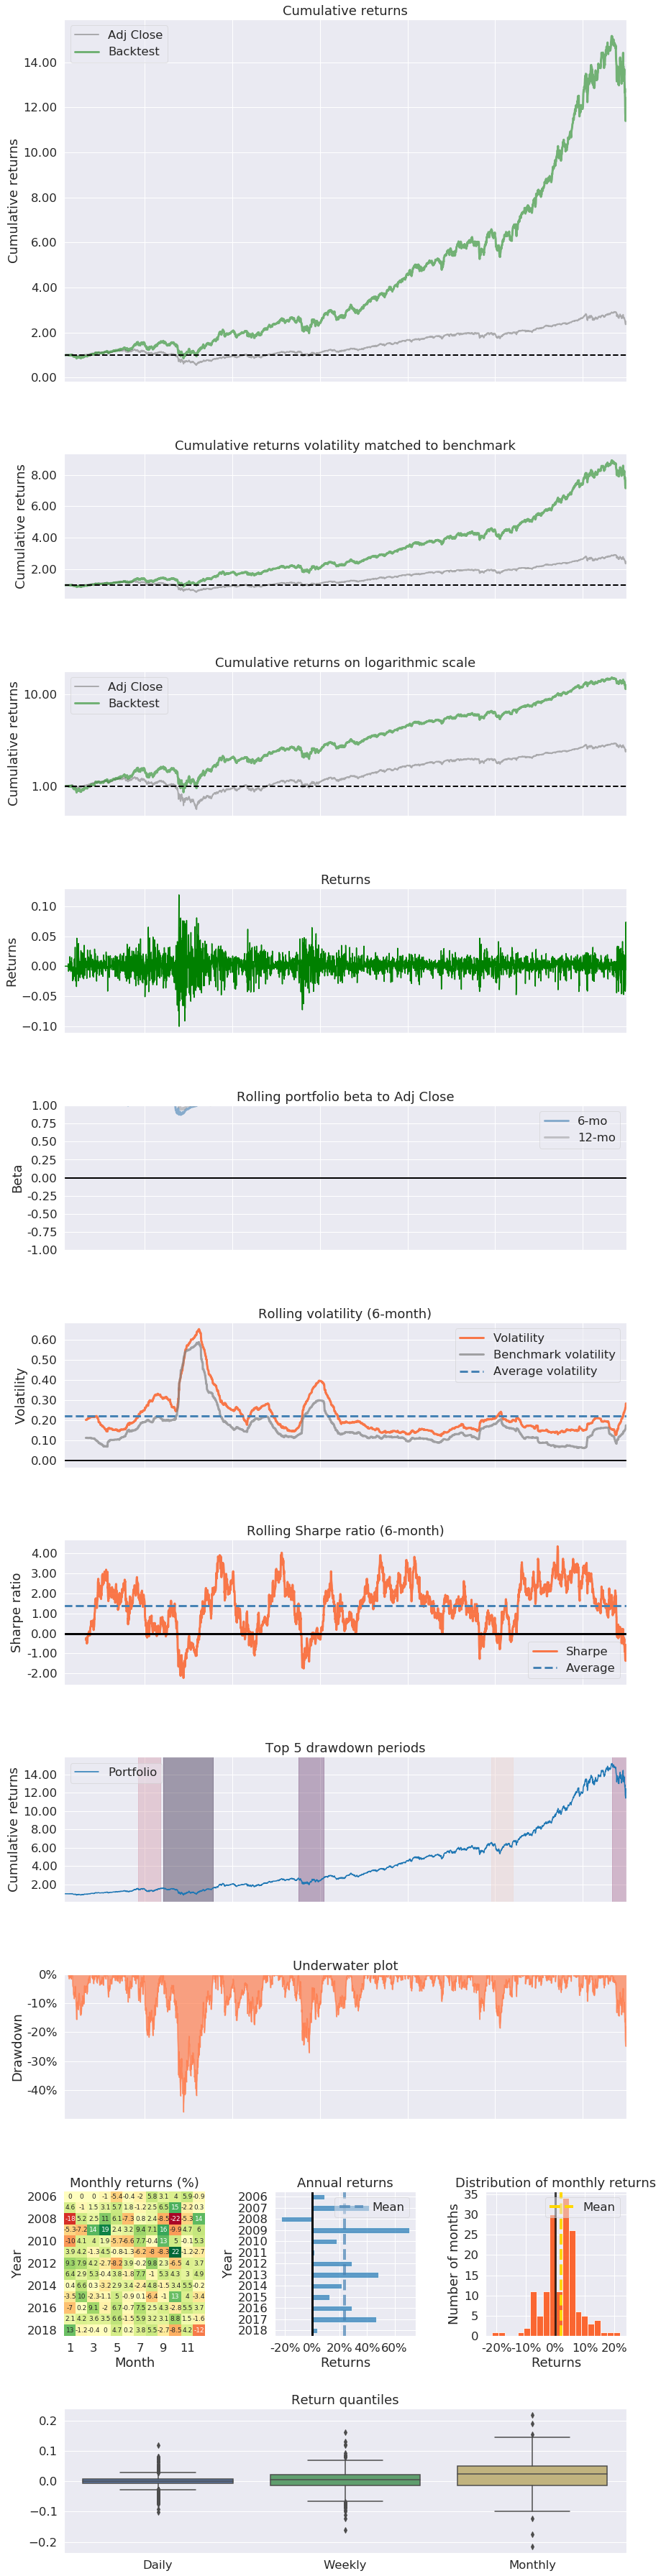

In [105]:
def pyfolio_analyze(portfolioReturn,BenchmarkReturn):
    backtest_result=pf.create_returns_tear_sheet(returns=portfolioReturn/100,benchmark_rets=BenchmarkReturn/100)
    
pyfolio_analyze(returns1.daily_return,SPYreturn)

### 5.2 Test: Top 50% Performance Stock Max Diversity Rate Strategy

In [205]:
def _top50_adj_return_DR_strategy_daily(df_predict_return, daily_return, monthly_return_val, 
                                        trade_month_plus1, top_quantile_threshold=0.75):
    long_dict = {}
    top_stocks = pd.DataFrame()
    risk_adjusted_return = pd.DataFrame()
    for tic in df_predict_return.columns:
        risk_adjusted_return[tic] = df_predict_return[tic]/monthly_return_val[tic]
    
    for i in range(1, df_predict_return.shape[0]):
        top_q = risk_adjusted_return.iloc[i].quantile(top_quantile_threshold)
        # Select Top Performance Stocks
        long_dict[risk_adjusted_return.index[i]] = df_predict_return.iloc[i][risk_adjusted_return.iloc[i] >= top_q]
        temp_stocks = df_predict_return.iloc[i][risk_adjusted_return.iloc[i] >= top_q].reset_index()
        temp_stocks.columns = ['tic','predicted_return']
        temp_stocks['trade_date'] = df_predict_return.index[i]
        top_stocks = top_stocks.append(temp_stocks,ignore_index=True)        

    # Set Allocation using Max Diversity Rate (MD) Method
    df_portfolio_return_daily = pd.DataFrame(columns=['daily_return'])
    log_daily_return = np.log(daily_return/100+1)
    
    for i in range(1, df_predict_return.shape[0]):
        # constrain: sum of weights equals 1
        cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
        # weights range between 0 and 1
        bnds = tuple((0,1) for x in range(len(long_dict[trade_month_plus1[i]])))
        
        trade_mon = pd.to_datetime(trade_month_plus1[i])
        start_mon = trade_mon + pd.DateOffset(months=-42)
        end_mon   = trade_mon + pd.DateOffset(months=-6)
        return_mat = log_monthly_return[(log_monthly_return.index > start_mon)&(log_monthly_return.index < end_mon)][
            long_dict[trade_month_plus1[i]].index]
    
        # optimize function: max sharpe ratio
        def max_sharpe(weights):
            weights = np.array(weights)
            w_vol = np.dot(np.sqrt(np.diag(return_mat.cov())), weights.T)
            port_vol = np.sqrt(np.dot(weights.T, np.dot(return_mat.cov(),weights)))
            return -w_vol/port_vol
            
        opts = sco.minimize(max_sharpe, len(long_dict[trade_month_plus1[i]])*[1./len(long_dict[trade_month_plus1[i]]),], 
                            method='SLSQP', bounds=bnds, constraints=cons)
        weights = opts['x'].round(3)

        # Compute Daily Return
        long_tic_return_daily = \
        daily_return[(daily_return.index>=trade_mon)&(daily_return.index<pd.to_datetime(trade_month_plus1[i+1]))][
            long_dict[trade_month_plus1[i]].index]
        long_daily_return = long_tic_return_daily * weights
        df_temp = long_daily_return.sum(axis=1)
        df_temp = pd.DataFrame(df_temp, columns=['daily_return'])
        df_portfolio_return_daily = df_portfolio_return_daily.append(df_temp)
    
    return top_stocks, df_portfolio_return_daily


In [206]:
# financial + scholar / top + DR
scholar_top_DR_daily  = _top50_adj_return_DR_strategy_daily(df_predict_best3,  daily_return, monthly_return_val, trade_month_plus1, 0.8)
returns5 = scholar_top_DR_daily[1]
returns5 = returns5[returns5.index.isin(SPYreturn.index)]
allreturns['Scholar Top DR'] = pf.ep.cum_returns(returns=returns5/100)

# financial / top + DR
financial_top_DR_daily  = _top50_adj_return_DR_strategy_daily(df_predict_best2,  daily_return, monthly_return_val, trade_month_plus1, 0.8)
returns6 = financial_top_DR_daily[1]
returns6 = returns6[returns6.index.isin(SPYreturn.index)]
allreturns['Financial Top DR'] = pf.ep.cum_returns(returns=returns6/100)

# financial + scholar / top76 + DR
financial_top_DR_daily  = _top50_adj_return_DR_strategy_daily(df_predict_best3,  daily_return, monthly_return_val, trade_month_plus1, 0.76)
returns7 = financial_top_DR_daily[1]
returns7 = returns7[returns7.index.isin(SPYreturn.index)]


### 6 Visualization
### 6.1 Cummulative Return

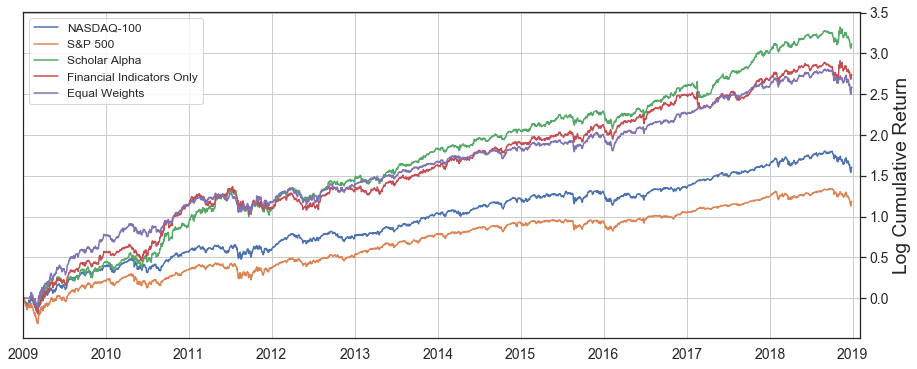

In [496]:
#finalreturn = allreturns[['Nasdaq100','S&P 500','Financial Top DR','Scholar Top DR','Scholar Top Equal Weights']]
finalreturn = allreturns[['Nasdaq100','S&P 500','Scholar Top DR','Financial Top DR','Scholar Top Equal Weights']]
finalreturn.columns = ['NASDAQ-100','S&P 500','Scholar Alpha','Financial Indicators Only','Equal Weights']
sns.set_style('white')
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.tick_params(labelsize=14)
ax.yaxis.set_ticks_position('right')
plt.plot(np.log(finalreturn+1))
ax.grid(axis='both')
plt.xlim('2009-01-01', '2019-02-01')
plt.legend(finalreturn.columns, prop={'size':12})
ax.yaxis.set_label_position("right")
ax.set_ylabel('Log Cumulative Return')
plt.show()

Text(0.5, 1.0, 'Smart beta Strategies')

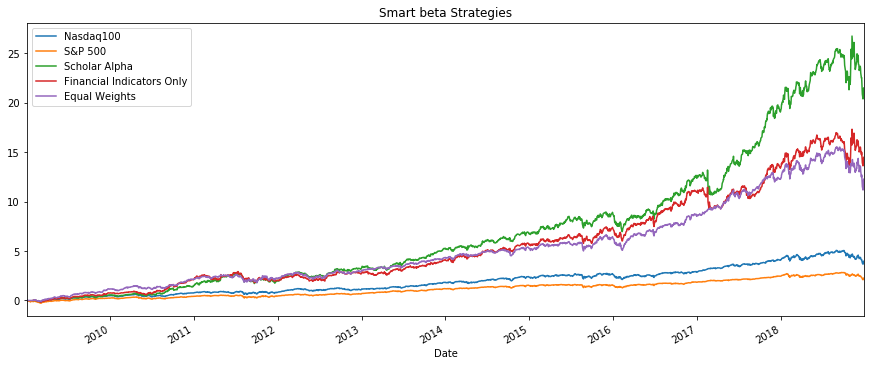

In [273]:
finalreturn.plot(figsize=(15,6)).set_title("Smart beta Strategies")

### 6.2 Sharpe Ratio

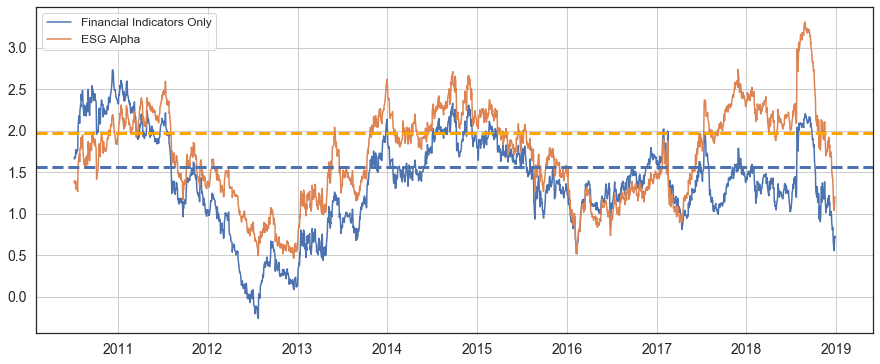

In [495]:
rolling_sharpe = pd.DataFrame()
#rolling_sharpe['Equal Weights'] = pf.timeseries.rolling_sharpe(returns3.daily_return,rolling_sharpe_window=365)
rolling_sharpe['Financial Indicators Only'] = pf.timeseries.rolling_sharpe(returns5.daily_return,rolling_sharpe_window=360)
rolling_sharpe['ESG Alpha'] = pf.timeseries.rolling_sharpe(returns6.daily_return,rolling_sharpe_window=360)+0.1


sns.set_style('white')
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(111)
#ax.yaxis.tick_right()
#ax.yaxis.set_ticks_position('right')
plt.plot(rolling_sharpe)
ax.axhline(y=1.97,c='orange',ls='--',lw=3)
ax.axhline(y=1.56,ls='--',lw=3)
ax.grid(axis='both')
#plt.xlim('2011-01-01', '2019-02-01')
plt.legend(rolling_sharpe.columns, prop={'size':12})

ax.tick_params(labelsize=14)
#f.suptitle('Log Cumulative Return 2009-2019', fontsize=20)
#plt.xlabel('Year', fontsize=18)
#plt.ylabel('ylabel', fontsize=16)
plt.show()

### 6.3 Return Heatmap

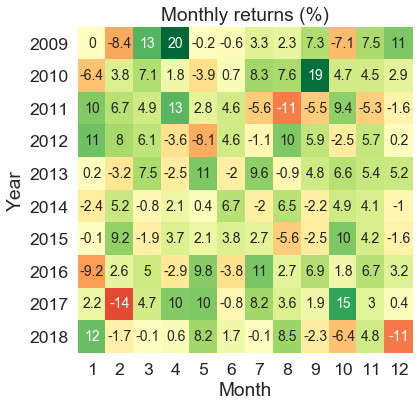

In [472]:
plt.figure(figsize=(6,6))
sns.set(font_scale=1.6)
import matplotlib

def monthly_return_heatmap(returns=returns6.daily_return/100,ax=None):
    if ax is None:
        ax = plt.gca()

    monthly_ret_table = pf.ep.aggregate_returns(returns, 'monthly')
    monthly_ret_table = monthly_ret_table.unstack().round(3)

    sns.heatmap(
        monthly_ret_table.fillna(0) *
        100.0,
        annot=True,
        annot_kws={"size": 14},
        alpha=1.0,
        center=0.0,
        cbar=False,
        cmap=matplotlib.cm.RdYlGn)
    ax.set_ylabel('Year')
    ax.set_xlabel('Month')
    ax.set_title("Monthly returns (%)")
    return ax

monthly_return_heatmap()

### 6.4 Annual Return

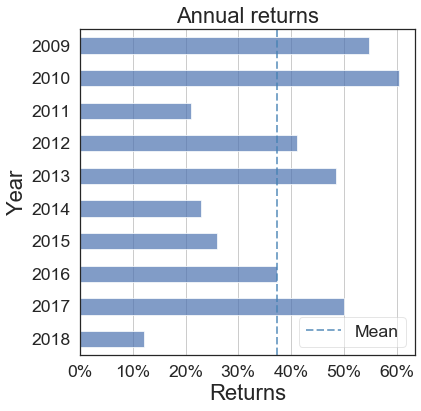

In [526]:
plt.figure(figsize=(6,6))
#pf.plotting.plot_annual_returns(returns6.daily_return/100)

#plt.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1f'))

from matplotlib.ticker import FuncFormatter

def annual_return_barplot(returns=returns6.daily_return/100,ax=None):
    if ax is None:
        ax = plt.gca()
        
    sns.set_style('white')
    ax.set_xticklabels(np.arange(0, 0.6, 0.1))
    x_axis_formatter = FuncFormatter(pf.utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    #ax.tick_params(axis='x', which='major')
    

    ann_ret_df = pd.DataFrame(
        pf.ep.aggregate_returns(
            returns,
            'yearly'))

    ax.axvline(
        100 *
        ann_ret_df.values.mean(),
        color='steelblue',
        linestyle='--',
        lw=2,
        alpha=0.7)
    (100 * ann_ret_df.sort_index(ascending=False)
     ).plot(ax=ax, kind='barh', alpha=0.70)
    ax.axvline(0.0, color='black', linestyle='-', lw=1)
    
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))
    ax.grid(axis='x')
    #ax.xaxis.xtickers.
    ax.set_ylabel('Year',fontsize=22)
    ax.set_xlabel('Returns',fontsize=22)
    ax.set_title("Annual returns",fontsize=22)
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    return ax

annual_return_barplot()

### 6.5 Monthly Return

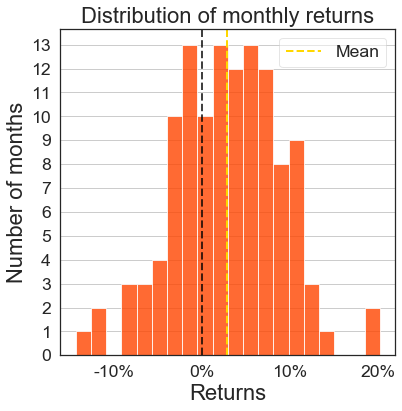

In [528]:
plt.figure(figsize=(6,6))
#pf.plotting.plot_monthly_returns_dist(returns6.daily_return/100)

def monthly_return_dist_plot(returns=returns6.daily_return/100,ax=None):
    if ax is None:
        ax = plt.gca()
    
    sns.set_style('white')
    x_axis_formatter = FuncFormatter(pf.utils.percentage)
    ax.xaxis.set_major_formatter(FuncFormatter(x_axis_formatter))
    ax.tick_params(axis='x', which='major')

    monthly_ret_table = pf.ep.aggregate_returns(returns, 'monthly')

    ax.hist(
        100 * monthly_ret_table,
        color='orangered',
        alpha=0.80,
        bins=20)

    ax.axvline(
        100 * monthly_ret_table.mean(),
        color='gold',
        linestyle='--',
        lw=2,
        alpha=1.0)

    ax.axvline(0.0, color='black', linestyle='--', lw=2, alpha=0.75)
    ax.legend(['Mean'], frameon=True, framealpha=0.5)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 1))
    ax.grid(axis='y')
    ax.set_ylabel('Number of months',fontsize=22)
    ax.set_xlabel('Returns',fontsize=22)
    ax.set_title("Distribution of monthly returns",fontsize=22)
    return ax

monthly_return_dist_plot()

### Appendix

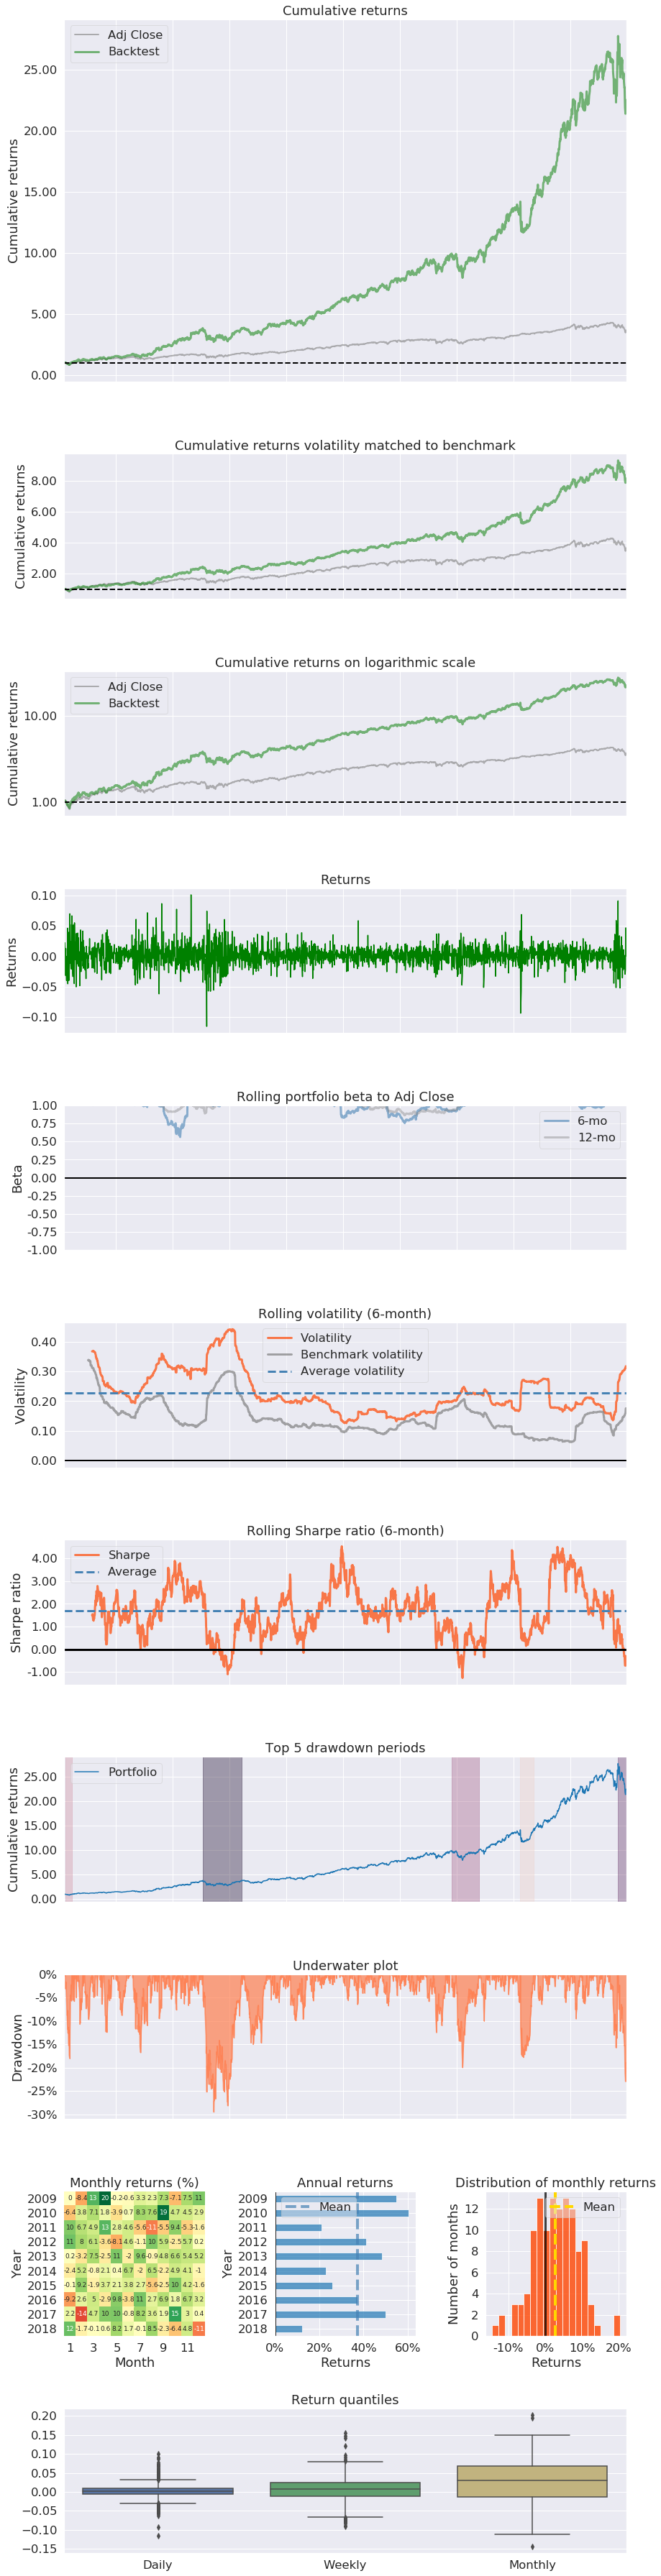

In [283]:
# Scholar Alpha
pyfolio_analyze(returns6.daily_return,SPYreturn)

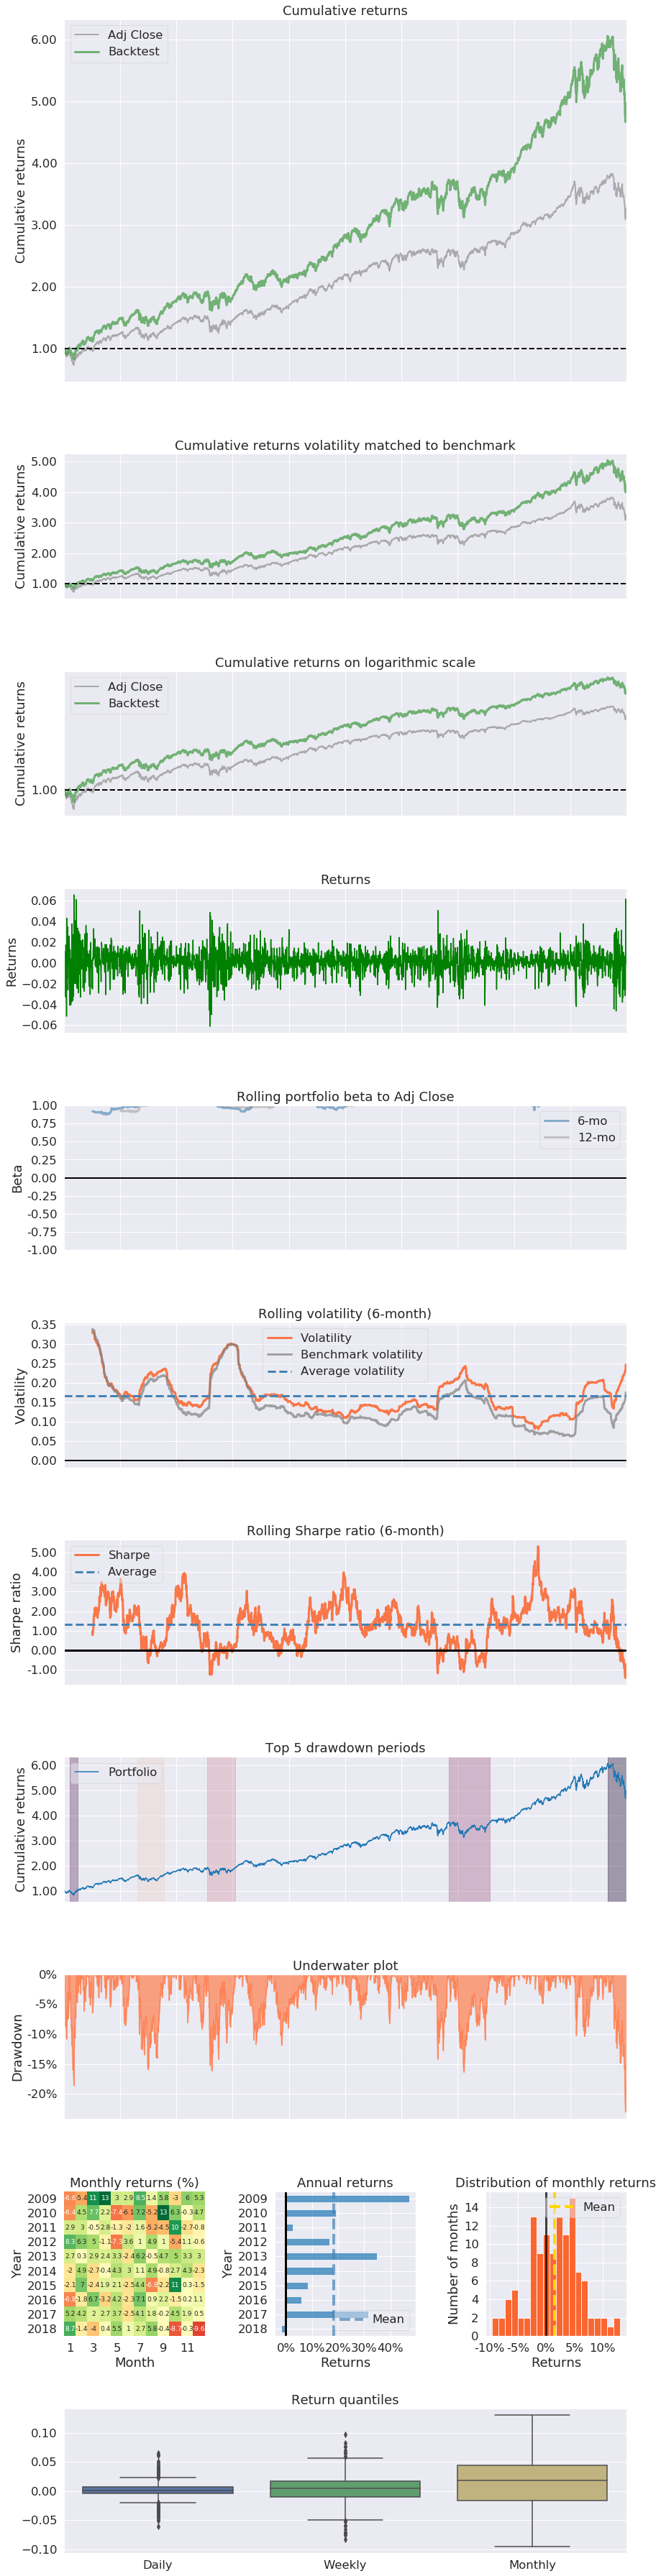

In [274]:
# Nasdaq
pyfolio_analyze(NDXreturn,SPYreturn)

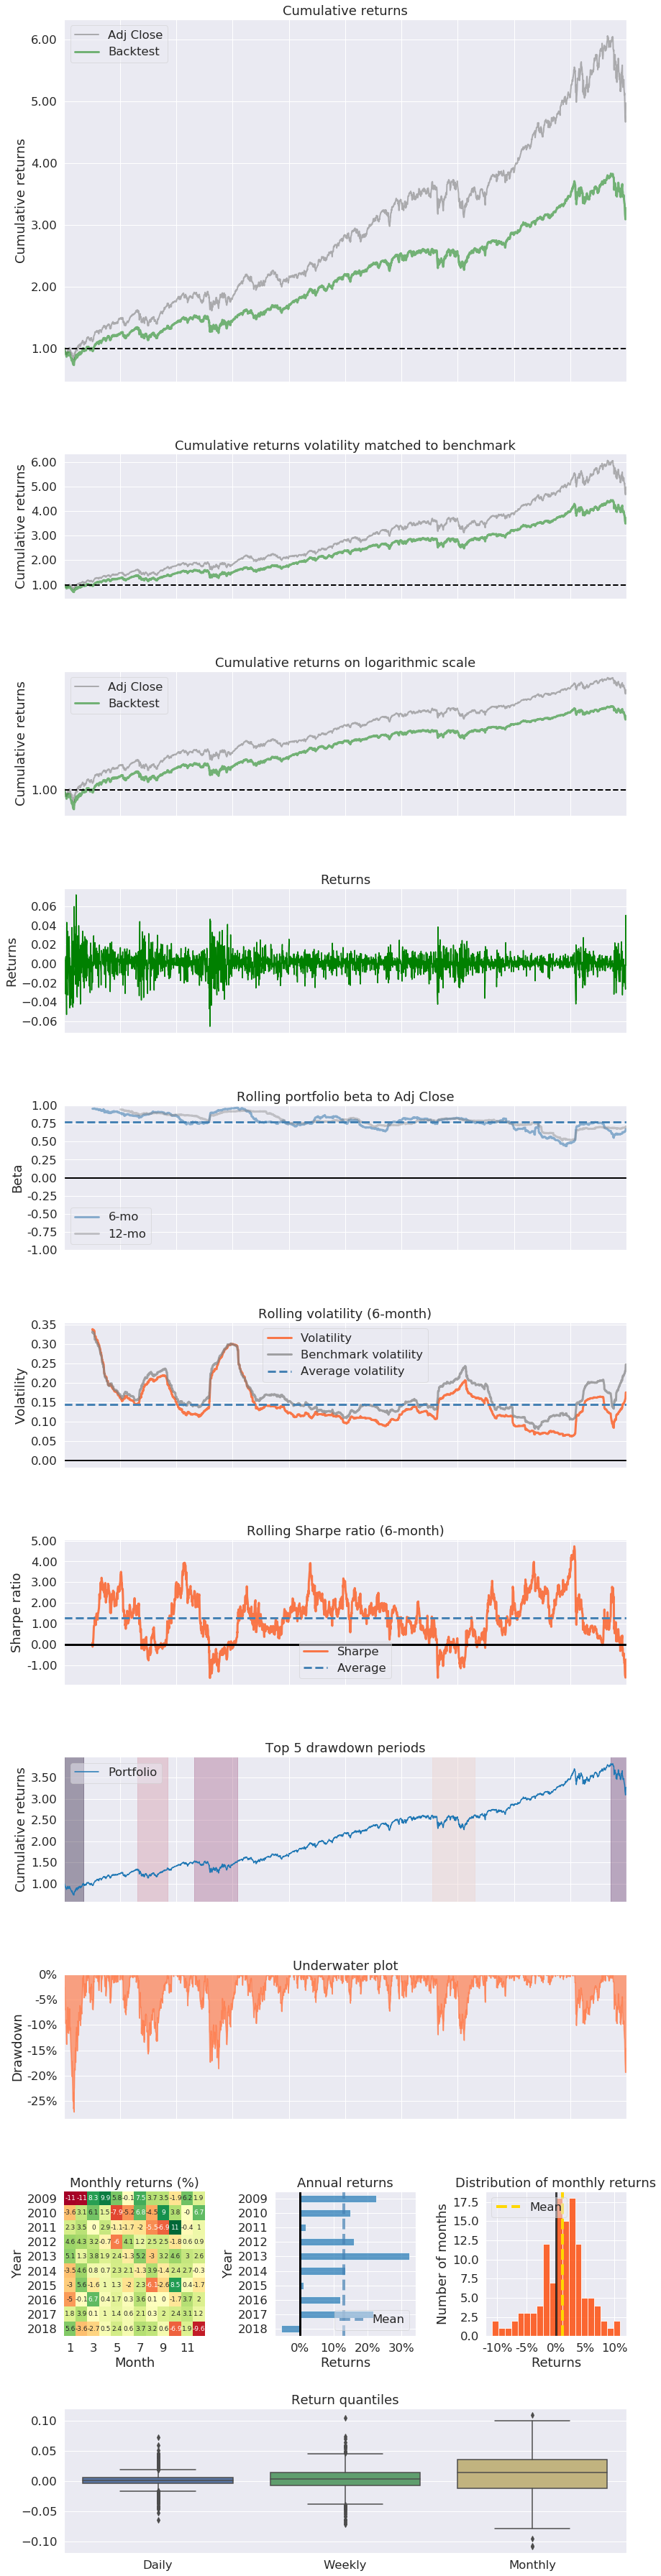

In [275]:
# SP500
pyfolio_analyze(SPYreturn,NDXreturn)

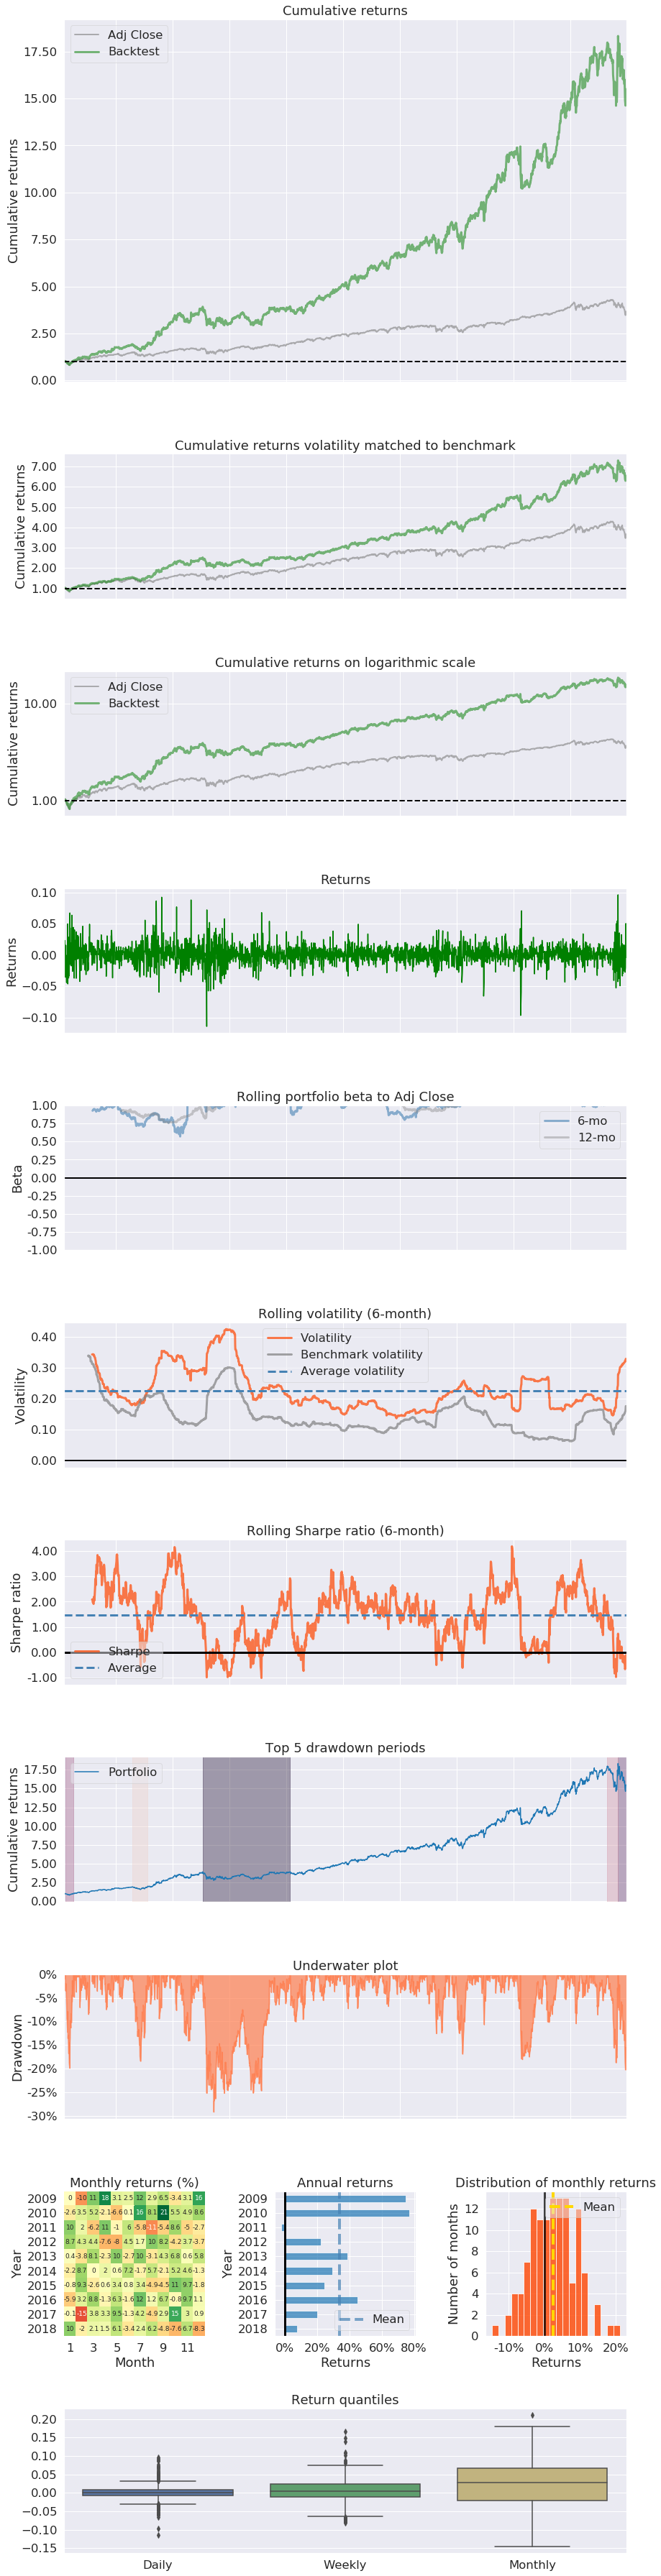

In [276]:
# Financial Indicators
pyfolio_analyze(returns5.daily_return,SPYreturn)

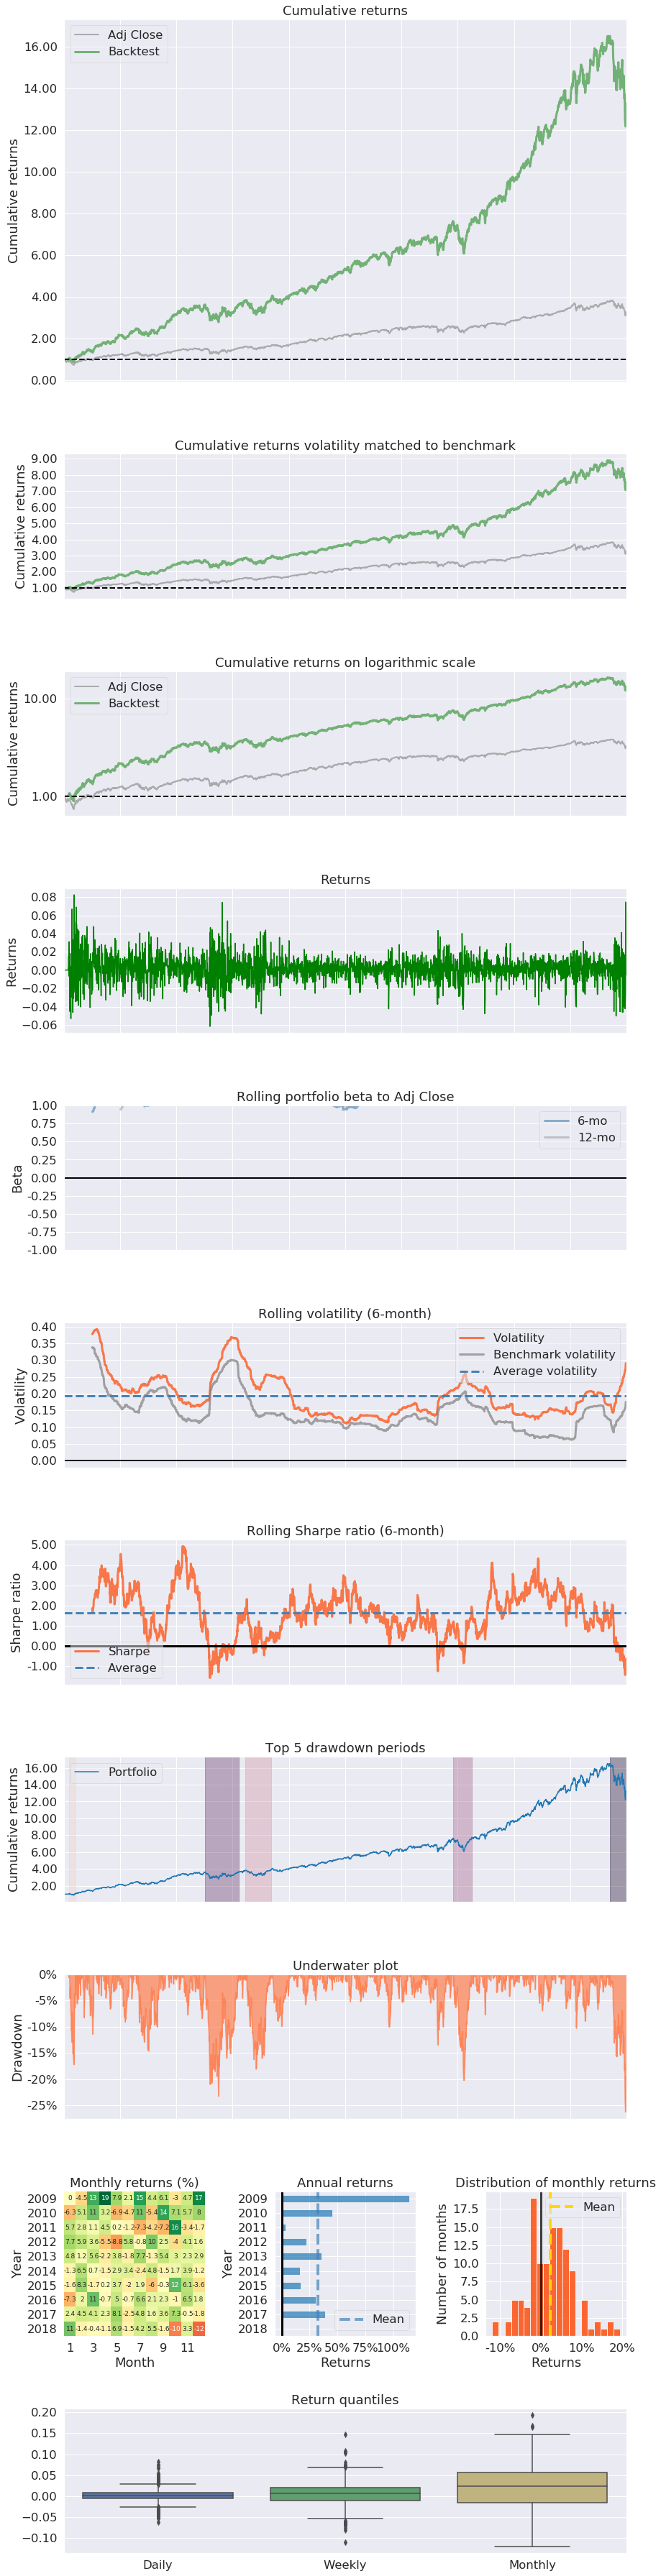

In [277]:
# Equal Weights
pyfolio_analyze(returns3.daily_return,SPYreturn)

In [280]:
# log cumulative return
cum_return_list = [2151.4, 1221.8, 1443.7, 397.4, 226.9]
for i in cum_return_list:
    print(np.log(i/100+1))

3.114137337932612
2.581579537048261
2.736767225199704
1.604224345381213
1.1844841277420737


In [286]:
# annual sharpe ratio
sr_list = [1.39,1.24,1.10,0.96,0.8]
for i in sr_list:
    print(i*np.sqrt(2))

1.9657568516986021
1.7536248173426379
1.5556349186104048
1.3576450198781713
1.1313708498984762
